In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Forecasting the population of the Austin Animal Center

This project uses data from the Austin Animal Center to forecast the expected population of the shelter. Forecasting the number of animals the shelter is likely to have in future is important for the shelter in terms of planning, budgeting and resourcing. 

The data I have used for this project can be downloaded from [here](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes).

## Data
### Initial exploration

In [2]:
aac = pd.read_csv('aac_intakes_outcomes.csv')

In [3]:
aac.shape

(79672, 41)

There are 79,672 observations in the data and 41 variables.

In [4]:
aac.loc[0, ]

age_upon_outcome                                                   10 years
animal_id_outcome                                                   A006100
date_of_birth                                           2007-07-09 00:00:00
outcome_subtype                                                         NaN
outcome_type                                                Return to Owner
sex_upon_outcome                                              Neutered Male
age_upon_outcome_(days)                                                3650
age_upon_outcome_(years)                                                 10
age_upon_outcome_age_group                                      (7.5, 10.0]
outcome_datetime                                        2017-12-07 14:07:00
outcome_month                                                            12
outcome_year                                                           2017
outcome_monthyear                                                   2017-12
outcome_week

Several of the variables are derivatives of the time the animal arrived at or left the shelter. 

In [5]:
aac.isnull().sum()

age_upon_outcome                  0
animal_id_outcome                 0
date_of_birth                     0
outcome_subtype               43324
outcome_type                     10
sex_upon_outcome                  1
age_upon_outcome_(days)           0
age_upon_outcome_(years)          0
age_upon_outcome_age_group        0
outcome_datetime                  0
outcome_month                     0
outcome_year                      0
outcome_monthyear                 0
outcome_weekday                   0
outcome_hour                      0
outcome_number                    0
dob_year                          0
dob_month                         0
dob_monthyear                     0
age_upon_intake                   0
animal_id_intake                  0
animal_type                       0
breed                             0
color                             0
found_location                    0
intake_condition                  0
intake_type                       0
sex_upon_intake             

There is very little data missing from the dataset. The outcome subtype is often missing but this may be because it is often not relevant (e.g. there appears to be no subtype needed if the animal was returned to owner).

### Checking

In [6]:
## These should all total 79,672.

print(sum(aac['age_upon_outcome_(years)'] >= aac['age_upon_intake_(years)']), ': age_upon_outcome > age_upon_intake', )
print(sum(aac['dob_year'] == pd.to_datetime(aac['date_of_birth']).apply(lambda x: x.year)), ': Year in date_of_birth = dob_year')
print(sum((aac['outcome_year'] - aac['dob_year'] - aac['age_upon_outcome_(years)'].astype(int)).isin([-1, 0, 1])), ': outcome_year - dob_year - age (years) = -1, 0 or 1')
print(sum(aac['animal_id_intake'] == aac['animal_id_outcome']), ': animal_id_intake = animal_id_outcome')
print(sum(pd.to_datetime(aac['outcome_datetime']) >= pd.to_datetime(aac['intake_datetime'])), ': outcome_datetime >= intake_datetime')
print(sum((pd.to_datetime(aac['outcome_datetime']) - pd.to_datetime(aac['intake_datetime'])) == aac['time_in_shelter']), ': outcome_datetime - intake_datetime = time_in_shelter')

79518 : age_upon_outcome > age_upon_intake
79672 : Year in date_of_birth = dob_year
79672 : outcome_year - dob_year - age (years) = -1, 0 or 1
79672 : animal_id_intake = animal_id_outcome
79672 : outcome_datetime >= intake_datetime
79672 : outcome_datetime - intake_datetime = time_in_shelter


Generally the data appears in good shape. Around 150 ages change in the wrong direction while animals are at the shelter, though this may because their ages are guessed when they arrive.

### Exploratory data analysis

#### Animal features

In [7]:
aac.animal_type.value_counts()

Dog      45366
Cat      29539
Other     4428
Bird       339
Name: animal_type, dtype: int64

In [8]:
aac.breed.value_counts()

Domestic Shorthair Mix                       23423
Pit Bull Mix                                  6256
Chihuahua Shorthair Mix                       4831
Labrador Retriever Mix                        4789
Domestic Medium Hair Mix                      2326
German Shepherd Mix                           1950
Bat Mix                                       1381
Domestic Longhair Mix                         1248
Australian Cattle Dog Mix                     1099
Siamese Mix                                    996
Bat                                            827
Dachshund Mix                                  811
Boxer Mix                                      683
Border Collie Mix                              662
Miniature Poodle Mix                           662
Catahoula Mix                                  480
Raccoon Mix                                    471
Rat Terrier Mix                                469
Australian Shepherd Mix                        468
Yorkshire Terrier Mix          

There are 2,155 different breeds which look to be mostly (though not exclusively) related to dogs. There is likely to be some overlap in the labels (e.g. the Jack Russell Terrier Mix might be the same as a Jack Russell Terrier/Shetland Sheepdog).

In [9]:
aac.color.value_counts()

Black/White                  8270
Black                        6673
Brown Tabby                  4471
Brown                        3598
White                        2835
Brown/White                  2516
Tan/White                    2462
Brown Tabby/White            2351
Orange Tabby                 2182
White/Black                  2172
Blue/White                   2127
Tricolor                     2031
Tan                          2022
Black/Tan                    1847
Black/Brown                  1619
White/Brown                  1604
Brown Brindle/White          1374
Brown/Black                  1367
Tortie                       1344
Blue                         1335
Calico                       1333
White/Tan                    1195
Blue Tabby                   1136
Orange Tabby/White           1105
Red                          1047
Red/White                     858
Torbie                        845
Brown Brindle                 728
Tan/Black                     637
Chocolate/Whit

There are 529 colors which again probably show some overlap (White/Tan vs Tan/White).

In [10]:
aac.intake_type.value_counts()

Stray                 55935
Owner Surrender       15028
Public Assist          4994
Wildlife               3464
Euthanasia Request      251
Name: intake_type, dtype: int64

In [11]:
intake_type = ['Stray', 'Owner Surrender', 'Public Assist', 'Wildlife', 'Euthanasia Request']
complete_years = [2017, 2016, 2015, 2014]
intake_dict = dict()

for t in intake_type:
    t_count = []
    for year in complete_years:
        t_count.append(aac.loc[(aac['intake_type'] == t) & (aac['intake_year'] == year), ].shape[0])
    t_count = np.array(t_count)
    intake_dict[str(t)] = t_count

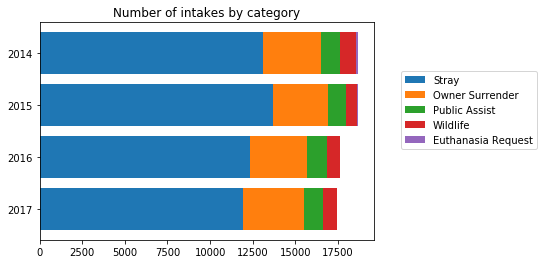

In [12]:
plt.barh(y=complete_years, width=intake_dict['Stray'], tick_label=complete_years, label='Stray')
plt.barh(y=complete_years, width=intake_dict['Owner Surrender'], left=intake_dict['Stray'], label='Owner Surrender')
plt.barh(y=complete_years, width=intake_dict['Public Assist'], left=(intake_dict['Stray'] + intake_dict['Owner Surrender']), label='Public Assist')
plt.barh(y=complete_years, width=intake_dict['Wildlife'], left=(intake_dict['Stray'] + intake_dict['Owner Surrender'] + intake_dict['Public Assist']), label='Wildlife')
plt.barh(y=complete_years, width=intake_dict['Euthanasia Request'], left=(intake_dict['Stray'] + intake_dict['Owner Surrender'] + intake_dict['Public Assist'] + intake_dict['Wildlife']), label='Euthanasia Request')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.5, 0.8))
plt.title('Number of intakes by category')
plt.show()

In [13]:
aac.outcome_type.value_counts()

Adoption           33594
Transfer           23799
Return to Owner    14791
Euthanasia          6244
Died                 690
Disposal             304
Rto-Adopt            179
Missing               46
Relocate              15
Name: outcome_type, dtype: int64

In [14]:
aac.loc[:, ['age_upon_intake_(years)', 'time_in_shelter_days']].describe()

,age_upon_intake_(years),time_in_shelter_days
count,79672.000000,79672.000000
mean,2.107785,16.757116
std,2.893175,41.679359
min,0.000000,0.000000
25%,0.164384,1.102083
50%,1.000000,4.987153
75%,3.000000,13.610764
max,25.000000,1606.194444


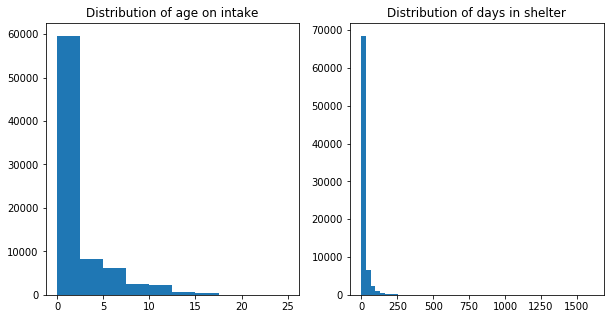

In [15]:
fig = plt.subplots(1, 2, figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
plt.hist(aac['age_upon_intake_(years)'])
plt.title('Distribution of age on intake')

ax2 = plt.subplot(1, 2, 2)
plt.hist(aac['time_in_shelter_days'], bins=50)
plt.title('Distribution of days in shelter')
plt.show()

50% of animals have an outcome within 5 days, however some animals are there much longer. The mean is 16.8 days, meaning that the distribution is skewed - it has a long tail as some animals are at the center for a long time. The age distribution is also skewed.

In [16]:
pd.to_datetime(aac.loc[:, 'intake_datetime']).describe()

count                   79672
unique                  56747
top       2016-09-23 12:00:00
freq                       64
first     2013-10-01 07:51:00
last      2018-03-29 18:20:00
Name: intake_datetime, dtype: object

In [17]:
pd.to_datetime(aac.loc[:, 'outcome_datetime']).describe()

count                   79672
unique                  65686
top       2016-04-18 00:00:00
freq                       39
first     2013-10-01 10:39:00
last      2018-04-03 18:43:00
Name: outcome_datetime, dtype: object

The dataset approximately covers the period from October 2013 to March 2018. 

#### Monthly trends

In [18]:
animal_types = ['Dog', 'Cat', 'Other', 'Bird']

In [19]:
monthly_in_out = dict()

for animal in animal_types:
    df_in = pd.DataFrame(aac.loc[aac['animal_type'] == animal, 'intake_monthyear'].value_counts())
    df_in.reset_index(inplace=True)
    df_in.rename(columns={'index': 'date', 'intake_monthyear': 'intake'}, inplace=True)
    df_in['date'] = pd.to_datetime(df_in['date'])
    df_in.sort_values('date', inplace=True)
    df_in.reset_index(inplace=True, drop=True)
    df_out = pd.DataFrame(aac.loc[aac['animal_type'] == animal, 'outcome_monthyear'].value_counts())
    df_out.reset_index(inplace=True)
    df_out.rename(columns={'index': 'date', 'outcome_monthyear': 'outtake'}, inplace=True)
    df_out['date'] = pd.to_datetime(df_out['date'])
    df_out.sort_values('date', inplace=True)
    df_out.reset_index(inplace=True, drop=True)
    monthly_in_out[str(animal)+'_in'] = df_in
    monthly_in_out[str(animal)+'_out'] = df_out

all_in = pd.DataFrame(aac.loc[:, 'intake_monthyear'].value_counts())
all_in.reset_index(inplace=True)
all_in.rename(columns={'index': 'date', 'intake_monthyear': 'intake'}, inplace=True)
all_in['date'] = pd.to_datetime(all_in['date'])
all_in.sort_values('date', inplace=True)
all_in.reset_index(inplace=True, drop=True)
    
all_out = pd.DataFrame(aac.loc[:, 'outcome_monthyear'].value_counts())
all_out.reset_index(inplace=True)
all_out.rename(columns={'index': 'date', 'outcome_monthyear': 'outtake'}, inplace=True)
all_out['date'] = pd.to_datetime(all_out['date'])
all_out.sort_values('date', inplace=True)
all_out.reset_index(inplace=True, drop=True)  

monthly_in_out['all_in'] = all_in
monthly_in_out['all_out'] = all_out

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


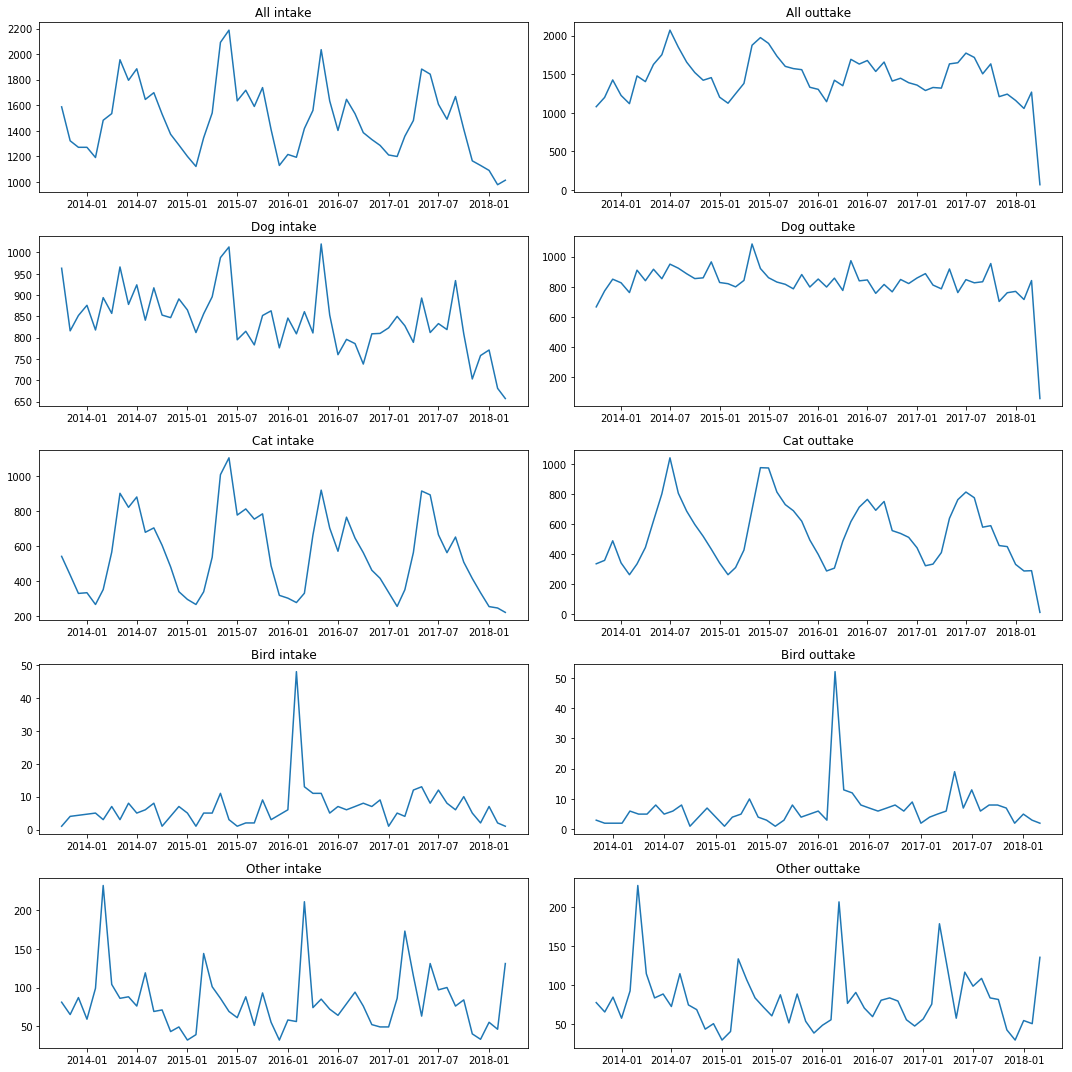

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

ax1 = plt.subplot(5, 2, 1)
ax1.plot(monthly_in_out['all_in']['date'], monthly_in_out['all_in']['intake'])
ax1.set_title('All intake')

ax2 = plt.subplot(5, 2, 2)
ax2.plot(monthly_in_out['all_out']['date'], monthly_in_out['all_out']['outtake'])
ax2.set_title('All outtake')

ax3 = plt.subplot(5, 2, 3)
ax3.plot(monthly_in_out['Dog_in']['date'], monthly_in_out['Dog_in']['intake'])
ax3.set_title('Dog intake')

ax4 = plt.subplot(5, 2, 4)
ax4.plot(monthly_in_out['Dog_out']['date'], monthly_in_out['Dog_out']['outtake'])
ax4.set_title('Dog outtake')

ax5 = plt.subplot(5, 2, 5)
ax5.plot(monthly_in_out['Cat_in']['date'], monthly_in_out['Cat_in']['intake'])
ax5.set_title('Cat intake')

ax6 = plt.subplot(5, 2, 6)
ax6.plot(monthly_in_out['Cat_out']['date'], monthly_in_out['Cat_out']['outtake'])
ax6.set_title('Cat outtake')

ax7 = plt.subplot(5, 2, 7)
ax7.plot(monthly_in_out['Bird_in']['date'], monthly_in_out['Bird_in']['intake'])
ax7.set_title('Bird intake')

ax8 = plt.subplot(5, 2, 8)
ax8.plot(monthly_in_out['Bird_out']['date'], monthly_in_out['Bird_out']['outtake'])
ax8.set_title('Bird outtake')

ax9 = plt.subplot(5, 2, 9)
ax9.plot(monthly_in_out['Other_in']['date'], monthly_in_out['Other_in']['intake'])
ax9.set_title('Other intake')

ax10 = plt.subplot(5, 2, 10)
ax10.plot(monthly_in_out['Other_out']['date'], monthly_in_out['Other_out']['outtake'])
ax10.set_title('Other outtake')

plt.tight_layout()
plt.show()

There is clear seasonality in the intake and outtake which is driven mostly by cats. There are many more cats being taken in and also adopted during the summer - this is probably 'kitten season'. The dog intake appears to be slowly declining over time. The bird intake and outtake is generally low with one large outlier - perhaps several birds were lost and found together? The 'other' intake also shows seasonality with spikes in the first quarter of the year. <br>

There is a tailing off of outtake at the end of the dataset. This is a function of the dataset only including animals which both entered and left the center during this period. It is likely that there is a corresponding number of animals leaving the center at the start of the period which are not visible in this dataset because they entered the center before the starting date of this dataset.

#### Daily trends

In [21]:
time_period = pd.date_range(pd.to_datetime('2013-10-01'), pd.to_datetime('2018-04-03'))
pop = pd.DataFrame()
pop['date'] = time_period

In [22]:
aac['date_in'] = pd.to_datetime(aac['intake_datetime']).apply(lambda x: x.date())
aac['date_out'] = pd.to_datetime(aac['outcome_datetime']).apply(lambda x: x.date())

In [23]:
pop_dict = dict()

for animal in animal_types:
    animal_in = []
    animal_out = []
    for date in time_period:
        animal_in.append(sum(date.date() == aac.loc[aac['animal_type'] == animal, 'date_in']))
        animal_out.append(sum(date.date() == aac.loc[aac['animal_type'] == animal, 'date_out']))
    pop_dict[str(animal)+'_in'] = animal_in
    pop_dict[str(animal)+'_out'] = animal_out

In [24]:
for animal in animal_types:
    pop[str(animal)+'_in'] = pop_dict[str(animal)+'_in']
    pop[str(animal)+'_out'] = pop_dict[str(animal)+'_out']
    pop[str(animal)+'_change'] = pop[str(animal)+'_in'] - pop[str(animal)+'_out']
    pop[str(animal)+'_pop'] = pop[str(animal)+'_change'].expanding(1).sum()

In [25]:
pop_total = pop.groupby(pop.columns.str.split("_").str[1],axis=1).sum()
pop = pd.concat([pop, pop_total], axis=1)

In [26]:
pop.columns = ['date', 'dog_in', 'dog_out', 'dog_change', 'dog_pop',
               'cat_in', 'cat_out', 'cat_change', 'cat_pop',
               'other_in', 'other_out', 'other_change', 'other_pop', 
               'bird_in', 'bird_out', 'bird_change', 'bird_pop',
               'all_change', 'all_in', 'all_out', 'all_pop']

In [27]:
pop.head()

,date,dog_in,dog_out,dog_change,dog_pop,cat_in,cat_out,cat_change,cat_pop,other_in,...,other_change,other_pop,bird_in,bird_out,bird_change,bird_pop,all_change,all_in,all_out,all_pop
0,2013-10-01,42,7,35,35.0,35,11,24,24.0,0,...,0,0.0,0,0,0,0.0,59,77,18,59.0
1,2013-10-02,28,6,22,57.0,22,12,10,34.0,3,...,1,1.0,0,0,0,0.0,33,53,20,92.0
2,2013-10-03,26,3,23,80.0,14,13,1,35.0,2,...,0,1.0,0,0,0,0.0,24,42,18,116.0
3,2013-10-04,30,5,25,105.0,16,0,16,51.0,1,...,1,2.0,0,0,0,0.0,42,47,5,158.0
4,2013-10-05,39,13,26,131.0,26,8,18,69.0,2,...,0,2.0,0,0,0,0.0,44,67,23,202.0


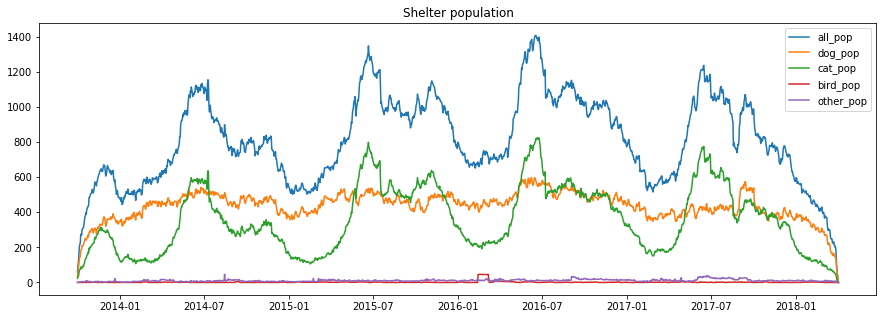

In [28]:
fig = plt.figure(figsize = (15, 5))

plt.plot(pop.date, pop.all_pop)
plt.plot(pop.date, pop.dog_pop)
plt.plot(pop.date, pop.cat_pop)
plt.plot(pop.date, pop.bird_pop)
plt.plot(pop.date, pop.other_pop)

plt.title('Shelter population')
plt.legend()
plt.show()

The shelter population is clearly driven by the changes in the cat population. The dog population remains relatively constant all year round and the bird and other populations are so small they are a negligible part of the total. There is a clear climb and tailing off of the data at the start and end resulting from the fact that the dataset only contains animals who both joined and exited the population within the timeframe.

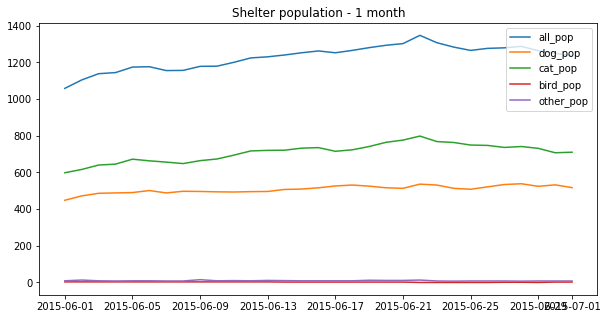

In [29]:
fig = plt.figure(figsize = (10, 5))

plt.plot('date', 'all_pop', data=pop.loc[pop['date'].isin(pd.date_range('2015-06-01', '2015-07-01')), ])
plt.plot('date', 'dog_pop', data=pop.loc[pop['date'].isin(pd.date_range('2015-06-01', '2015-07-01')), ])
plt.plot('date', 'cat_pop', data=pop.loc[pop['date'].isin(pd.date_range('2015-06-01', '2015-07-01')), ])
plt.plot('date', 'bird_pop', data=pop.loc[pop['date'].isin(pd.date_range('2015-06-01', '2015-07-01')), ])
plt.plot('date', 'other_pop', data=pop.loc[pop['date'].isin(pd.date_range('2015-06-01', '2015-07-01')), ])

plt.title('Shelter population - 1 month')
plt.legend()
plt.show()

There is no obvious weekly seasonality.

### Data cleaning

The first and last three months of the population data will be discarded. This is because the original dataset contains only animals which both joined and left the center during the period, so some of the center population is missing. The median stay for an animal is 5 days, and the mean is 17 days. By discarding the first and last three months of population data it can be fairly certain that the population numbers are not significantly skewed by animals arriving and leaving the center who are not included in the dataset.
<br>

The missing values will not be filled at this time as there is no intent to use any of the variables with missing values in this project.

In [30]:
pop_4yr = pop.loc[(pop['date'] >= '2014-01-01') & (pop['date'] <= '2017-12-31'), ]
pop_4yr.reset_index(inplace=True, drop=True)

In [31]:
pop_4yr.shape

(1461, 21)

In [32]:
pop_4yr.head()

,date,dog_in,dog_out,dog_change,dog_pop,cat_in,cat_out,cat_change,cat_pop,other_in,...,other_change,other_pop,bird_in,bird_out,bird_change,bird_pop,all_change,all_in,all_out,all_pop
0,2014-01-01,39,37,2,347.0,7,11,-4,123.0,2,...,1,5.0,0,0,0,0.0,-1,48,49,475.0
1,2014-01-02,34,25,9,356.0,11,14,-3,120.0,4,...,-2,3.0,0,0,0,0.0,4,49,45,479.0
2,2014-01-03,29,40,-11,345.0,8,13,-5,115.0,0,...,-1,2.0,0,0,0,0.0,-17,37,54,462.0
3,2014-01-04,38,23,15,360.0,13,6,7,122.0,0,...,0,2.0,0,0,0,0.0,22,51,29,484.0
4,2014-01-05,20,54,-34,326.0,11,12,-1,121.0,1,...,0,2.0,0,0,0,0.0,-35,32,67,449.0


### Supplementary data
#### Population of Austin, Texas, over time

The information comes from the census, [here](https://factfinder.census.gov/bkmk/table/1.0/en/PEP/2018/PEPANNRES/1620000US4805000).

In [33]:
austin_pop = pd.read_csv('./austin_pop/PEP_2018_PEPANNRES_with_ann.csv')

In [34]:
austin_pop = austin_pop.T
austin_pop.set_index(0, inplace=True)
austin_pop = austin_pop.T

In [35]:
austin_pop.columns = ['id1', 'id2', 'place', '2010-census', '2010-base', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018' ]

In [36]:
austin_pop_4yr = austin_pop.drop(['id1', 'id2', 'place', '2010-census', '2010-base', '2010', '2011', '2012', '2013', '2018'], axis=1)

In [37]:
austin_pop_4yr = austin_pop_4yr.T

In [38]:
austin_pop_4yr.reset_index(inplace=True)

In [39]:
austin_pop_4yr.columns = ['year', 'population']
austin_pop_4yr['year'] = austin_pop_4yr['year'].apply(lambda x: int(x))

In [40]:
austin_pop_4yr.head()

,year,population
0,2014,901734
1,2015,921545
2,2016,939768
3,2017,951750


#### Labor force and unemployment

In [41]:
austin_empl = pd.read_excel('austin-bureau-labor-stats2.xlsx')

In [42]:
austin_empl_4yr_str = austin_empl.loc[(austin_empl['Year'] > 2013) & (austin_empl['Year'] < 2018), ]
austin_empl_4yr_str.reset_index(inplace=True, drop=True)

In [43]:
austin_empl_4yr_str.head()

,Year,Period,labor force,employment,unemployment,unemployment rate
0,2014,Jan,1035195(R),987600(R),47595(R),4.6(R)
1,2014,Feb,1042912(R),994851(R),48061(R),4.6(R)
2,2014,Mar,1048496(R),1001150(R),47346(R),4.5(R)
3,2014,Apr,1044885(R),1005105(R),39780(R),3.8(R)
4,2014,May,1046702(R),1003032(R),43670(R),4.2(R)


In [44]:
austin_empl_4yr = pd.DataFrame({'monthyear': austin_empl_4yr_str['Year'].map(str) + ' ' + austin_empl_4yr_str['Period']})
austin_empl_4yr['monthyear'] = pd.to_datetime(austin_empl_4yr['monthyear'])

for col in ['labor force', 'employment', 'unemployment', 'unemployment rate']:
    new_col = austin_empl_4yr_str[col].str.split('\(R\)', expand=True)
    austin_empl_4yr[col] = new_col[0]
    austin_empl_4yr[col].apply(lambda x: float(x))

In [45]:
austin_empl_4yr.head()

,monthyear,labor force,employment,unemployment,unemployment rate
0,2014-01-01,1035195,987600,47595,4.6
1,2014-02-01,1042912,994851,48061,4.6
2,2014-03-01,1048496,1001150,47346,4.5
3,2014-04-01,1044885,1005105,39780,3.8
4,2014-05-01,1046702,1003032,43670,4.2


In [46]:
austin_empl_4yr.tail()

,monthyear,labor force,employment,unemployment,unemployment rate
43,2017-08-01,1158965,1120214,38751,3.3
44,2017-09-01,1171048,1136122,34926,3.0
45,2017-10-01,1169309,1136714,32595,2.8
46,2017-11-01,1174771,1140548,34223,2.9
47,2017-12-01,1173564,1140501,33063,2.8


### All data together

In [47]:
data_4yr = pop_4yr.copy()

data_4yr['austin_pop'] = pop_4yr['date'].apply(lambda x: austin_pop_4yr.loc[austin_pop_4yr.year == x.year, 'population'].values[0])
data_4yr['austin_lf'] = pop_4yr['date'].apply(lambda x: austin_empl_4yr.loc[austin_empl_4yr.monthyear == (pd.to_datetime(str(x.year) + ' ' + str(x.month))), 'labor force'].values[0])
data_4yr['austin_ur'] = pop_4yr['date'].apply(lambda x: austin_empl_4yr.loc[austin_empl_4yr.monthyear == (pd.to_datetime(str(x.year) + ' ' + str(x.month))), 'unemployment rate'].values[0])

In [48]:
data_4yr.head()

,date,dog_in,dog_out,dog_change,dog_pop,cat_in,cat_out,cat_change,cat_pop,other_in,...,bird_out,bird_change,bird_pop,all_change,all_in,all_out,all_pop,austin_pop,austin_lf,austin_ur
0,2014-01-01,39,37,2,347.0,7,11,-4,123.0,2,...,0,0,0.0,-1,48,49,475.0,901734,1035195,4.6
1,2014-01-02,34,25,9,356.0,11,14,-3,120.0,4,...,0,0,0.0,4,49,45,479.0,901734,1035195,4.6
2,2014-01-03,29,40,-11,345.0,8,13,-5,115.0,0,...,0,0,0.0,-17,37,54,462.0,901734,1035195,4.6
3,2014-01-04,38,23,15,360.0,13,6,7,122.0,0,...,0,0,0.0,22,51,29,484.0,901734,1035195,4.6
4,2014-01-05,20,54,-34,326.0,11,12,-1,121.0,1,...,0,0,0.0,-35,32,67,449.0,901734,1035195,4.6


In [49]:
data_4yr.tail()

,date,dog_in,dog_out,dog_change,dog_pop,cat_in,cat_out,cat_change,cat_pop,other_in,...,bird_out,bird_change,bird_pop,all_change,all_in,all_out,all_pop,austin_pop,austin_lf,austin_ur
1456,2017-12-27,27,29,-2,358.0,7,11,-4,239.0,2,...,0,0,0.0,-6,36,42,606.0,951750,1173564,2.8
1457,2017-12-28,21,23,-2,356.0,6,15,-9,230.0,4,...,0,0,0.0,-11,31,42,595.0,951750,1173564,2.8
1458,2017-12-29,24,27,-3,353.0,8,20,-12,218.0,0,...,0,0,0.0,-15,32,47,580.0,951750,1173564,2.8
1459,2017-12-30,33,20,13,366.0,5,15,-10,208.0,2,...,0,0,0.0,4,40,36,584.0,951750,1173564,2.8
1460,2017-12-31,29,34,-5,361.0,11,15,-4,204.0,0,...,0,0,0.0,-9,40,49,575.0,951750,1173564,2.8
